In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, TensorDataset, random_split

import zipfile

构建数据集

In [2]:
full_data_path = "../data/full_data.csv"
full = pd.read_csv(full_data_path)

In [3]:
# 取出训练集样本和标签，测试集样本，并转换为numpy类型
train_labels = full.iloc[:891, 0].to_numpy()
print(f"训练集标签：\n{train_labels.shape}, 类型：{type(train_labels)}")

train_inputs = full.iloc[:891, 1:].to_numpy()
print(f"训练集样本：\n{train_inputs.shape}, 类型：{type(train_inputs)}")

test_inputs = full.iloc[891:, 1:].to_numpy()
print(f"测试集样本：\n{test_inputs.shape}, 类型：{type(test_inputs)}")

训练集标签：
(891,), 类型：<class 'numpy.ndarray'>
训练集样本：
(891, 11), 类型：<class 'numpy.ndarray'>
测试集样本：
(418, 11), 类型：<class 'numpy.ndarray'>


In [4]:
# 将数据转换为tensor类型
train_labels = torch.from_numpy(train_labels).to(torch.long)
print(f"训练集标签：\n{train_labels.size()}, 类型：{type(train_labels)}")

train_inputs = torch.from_numpy(train_inputs).to(torch.float32)
print(f"训练集样本：\n{train_inputs.size()}, 类型：{type(train_inputs)}")

test_inputs = torch.from_numpy(test_inputs).to(torch.float32)
print(f"测试集样本：\n{test_inputs.size()}, 类型：{type(test_inputs)}")

训练集标签：
torch.Size([891]), 类型：<class 'torch.Tensor'>
训练集样本：
torch.Size([891, 11]), 类型：<class 'torch.Tensor'>
测试集样本：
torch.Size([418, 11]), 类型：<class 'torch.Tensor'>


In [5]:
# 将样本和标签构建成数据集，以便使用DataLoader来自动生成batch训练
dataset = TensorDataset(train_inputs, train_labels)
dataset_len = len(dataset)
print(f"数据集大小：{dataset_len}")

# 将数据集进一步划分为训练集和验证集(7:3，大概训练集624个，验证集267个)
torch.manual_seed(1)
train_dataset, valid_dataset = random_split(dataset, lengths=[624, 267])
print(f"数据集样本大小：{len(train_dataset)}, 验证集样本大小：{len(valid_dataset)}")

数据集大小：891
数据集样本大小：624, 验证集样本大小：267


构建模型

In [6]:
class Net(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.lin1 = nn.Linear(input_size, 44)
        self.lin2 = nn.Linear(44, 22)
        self.lin3 = nn.Linear(22, 11)
        self.lin4 = nn.Linear(11, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        x = self.relu(self.lin3(x))
        x = self.relu(self.lin4(x))
        return x

# 定义模型
net = Net(11, 2)
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
net.apply(init_normal)

Net(
  (lin1): Linear(in_features=11, out_features=44, bias=True)
  (lin2): Linear(in_features=44, out_features=22, bias=True)
  (lin3): Linear(in_features=22, out_features=11, bias=True)
  (lin4): Linear(in_features=11, out_features=2, bias=True)
  (relu): ReLU()
)

In [7]:
# 定义batch大小
batch_size = 32
train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=batch_size*2)

# 定义优化器46
optimizer = torch.optim.Adam(net.parameters(), lr=0.0046)
# 定义损失函数，分类问题使用交叉熵损失函数
loss_fn = torch.nn.CrossEntropyLoss()

# 定义迭代次数
epochs = 30

train_acc_list = []  #记录训练集的识别精度
valid_acc_list = []   #记录测试集的识别精度

print("开始训练：\n")
for i in range(epochs):
    loss = 0
    train_correct = 0
    # 在训练集上训练，并计算准确率
    for inputs, labels in train_dataset_loader:
        optimizer.zero_grad()
        # 前向传播计算输出
        outputs = net(inputs)
        # 找出输出中最大值的索引下标
        _, idx = outputs.max(dim=1)
        train_correct += (idx == labels).sum()
        # 计算损失
        loss = loss_fn(outputs, labels)
        # 反向传播计算梯度
        loss.backward()
        # 优化参数
        optimizer.step()
        
    # 寻找出训练集准确率不低的模型
    train_accuracy = train_correct / len(train_dataset)
    train_acc_list.append(train_accuracy)


    # 在验证集上计算准确率
    valid_correct = 0
    for inputs, labels in valid_dataset_loader:
        outputs = net(inputs)
        _, idx = outputs.max(dim=1)
        valid_correct += (idx == labels).sum()

    valid_accuracy = valid_correct / len(valid_dataset)
    valid_acc_list.append(valid_accuracy)
    
    train_metrics = loss.item(), train_accuracy
    print("Epoch [%d/%d] Loss=%.4f" %(i+1, epochs, loss.item()), end='')
    print(", 训练集准确率：%.4f%%" %(train_accuracy * 100), end='')
    print("， 验证集准确率：%.4f%%" %(valid_accuracy*100))
    
save_path = 'net.pth'
# 保存模型，字典形式
torch.save(net.state_dict(), save_path)

开始训练：

Epoch [1/30] Loss=0.6893, 训练集准确率：43.7500%， 验证集准确率：67.4157%
Epoch [2/30] Loss=0.6933, 训练集准确率：66.6667%， 验证集准确率：65.5431%
Epoch [3/30] Loss=0.6668, 训练集准确率：69.0705%， 验证集准确率：67.0412%
Epoch [4/30] Loss=0.6902, 训练集准确率：69.8718%， 验证集准确率：68.1648%
Epoch [5/30] Loss=0.6957, 训练集准确率：70.0321%， 验证集准确率：67.4157%
Epoch [6/30] Loss=0.6694, 训练集准确率：70.9936%， 验证集准确率：71.5356%
Epoch [7/30] Loss=0.6894, 训练集准确率：70.9936%， 验证集准确率：65.1685%
Epoch [8/30] Loss=0.6370, 训练集准确率：72.7564%， 验证集准确率：71.9101%
Epoch [9/30] Loss=0.5959, 训练集准确率：74.6795%， 验证集准确率：69.2884%
Epoch [10/30] Loss=0.7082, 训练集准确率：76.2821%， 验证集准确率：72.2846%
Epoch [11/30] Loss=0.6849, 训练集准确率：76.4423%， 验证集准确率：72.6592%
Epoch [12/30] Loss=0.7634, 训练集准确率：77.4038%， 验证集准确率：72.6592%
Epoch [13/30] Loss=0.6660, 训练集准确率：73.3974%， 验证集准确率：68.5393%
Epoch [14/30] Loss=0.7123, 训练集准确率：76.7628%， 验证集准确率：71.5356%
Epoch [15/30] Loss=0.6955, 训练集准确率：78.8462%， 验证集准确率：68.5393%
Epoch [16/30] Loss=0.5924, 训练集准确率：77.7244%， 验证集准确率：74.5318%
Epoch [17/30] Loss=0.6692, 训练集准确率：78.5256%

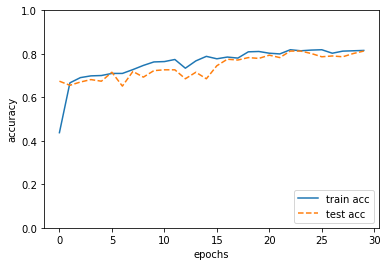

In [8]:
# 绘制训练集与验证集识别精度比较的图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, valid_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

预测数据

In [9]:
TEST_PATH = "../titanic/test.csv"
SUBMISSION_PATH = "../predict/submission.csv"
test_data = pd.read_csv(TEST_PATH) # 418条

In [10]:
print(f"测试集大小：{len(test_inputs)}, 测试集类型:{type(test_inputs)}")

测试集大小：418, 测试集类型:<class 'torch.Tensor'>


In [11]:
# 创建模型
net = Net(11, 2)
# 加载训练好的模型
net.load_state_dict(torch.load('net.pth'))
# 前向计算输出
outputs = net(test_inputs)
print(f"输出数据的大小：{outputs.size()}")

输出数据的大小：torch.Size([418, 2])


In [12]:
# 从输出数据中，找出每一行的最大值索引，即对应的预测数据，Survived是否生还
_, predict = outputs.max(dim=1)
# 转换为numpy数据类型
predict = predict.numpy()
# print(f"预测结果的大小：{predict.shape}, 预测数据：\n{predict}")

In [13]:
# 查看读取的测试文件内容
print(f"读取的测试文件：\n{test_data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
读取的测试文件：
None


In [14]:
# 从测试csv文件中取出PassengerId，并转换为numpy数据类型
passenger_id = test_data['PassengerId'].to_numpy()
# print(f"id数据的大小：{passenger_id.shape}, 数据:\n{passenger_id}")

In [15]:
# 将PassengerId与预测结果，两两组合，构建成DataFrame类型，再写入到csv文件中
data = zip(passenger_id, predict)
result = pd.DataFrame(data=data, columns=['PassengerId', 'Survived'])
result.to_csv(SUBMISSION_PATH, index=None)